Methodology for each model is set up the same - steps are broken down below:

Train Test and Cross Validation

In [19]:
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.tree import DecisionTreeClassifier


Loading the data and seperating the target variable (Diabetes Status)

In [20]:

data_path = '/workspaces/Final-Year-Project/Cleaned Data/TrainTestData.csv'
df = pd.read_csv(data_path)

X = df.drop('Diabetes Status', axis=1)
y = df['Diabetes Status']


Scaling features 

In [21]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Creating decision tree and hyper params

In [22]:
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'max_depth': [3, 4, 5, 6, 7],  
    'min_samples_split': [2],
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(dt, param_grid, scoring='f1', cv=kf, n_jobs=-1, verbose=1)


Training the model and savingnthe best params

In [23]:
grid_search.fit(X_scaled, y)

best_dt = grid_search.best_estimator_

print(grid_search.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'max_depth': 4, 'min_samples_split': 2}


Loading and preparing validation data 

In [24]:

valid_path = "/workspaces/Final-Year-Project/Cleaned Data/ValidationData.csv"
df_valid = pd.read_csv(valid_path)

X_valid = df_valid.drop('Diabetes Status', axis=1)
y_valid = df_valid['Diabetes Status']

X_valid_scaled = scaler.transform(X_valid)


Using the model on validation data

In [25]:
y_pred_valid = best_dt.predict(X_valid_scaled)


Performance and confusion matrix metrics 

In [ ]:
print(f"DT - Validation Classification Report:")
print(classification_report(y_valid, y_pred_valid))

print("DT - Validation Confusion Matrix:")
print(confusion_matrix(y_valid, y_pred_valid))


📌 DT - Validation Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.65      0.71       178
           1       0.71      0.83      0.77       186

    accuracy                           0.74       364
   macro avg       0.75      0.74      0.74       364
weighted avg       0.75      0.74      0.74       364

🟦 DT - Validation Confusion Matrix:
[[115  63]
 [ 31 155]]


Manual creation of DT diagram using unscaled data

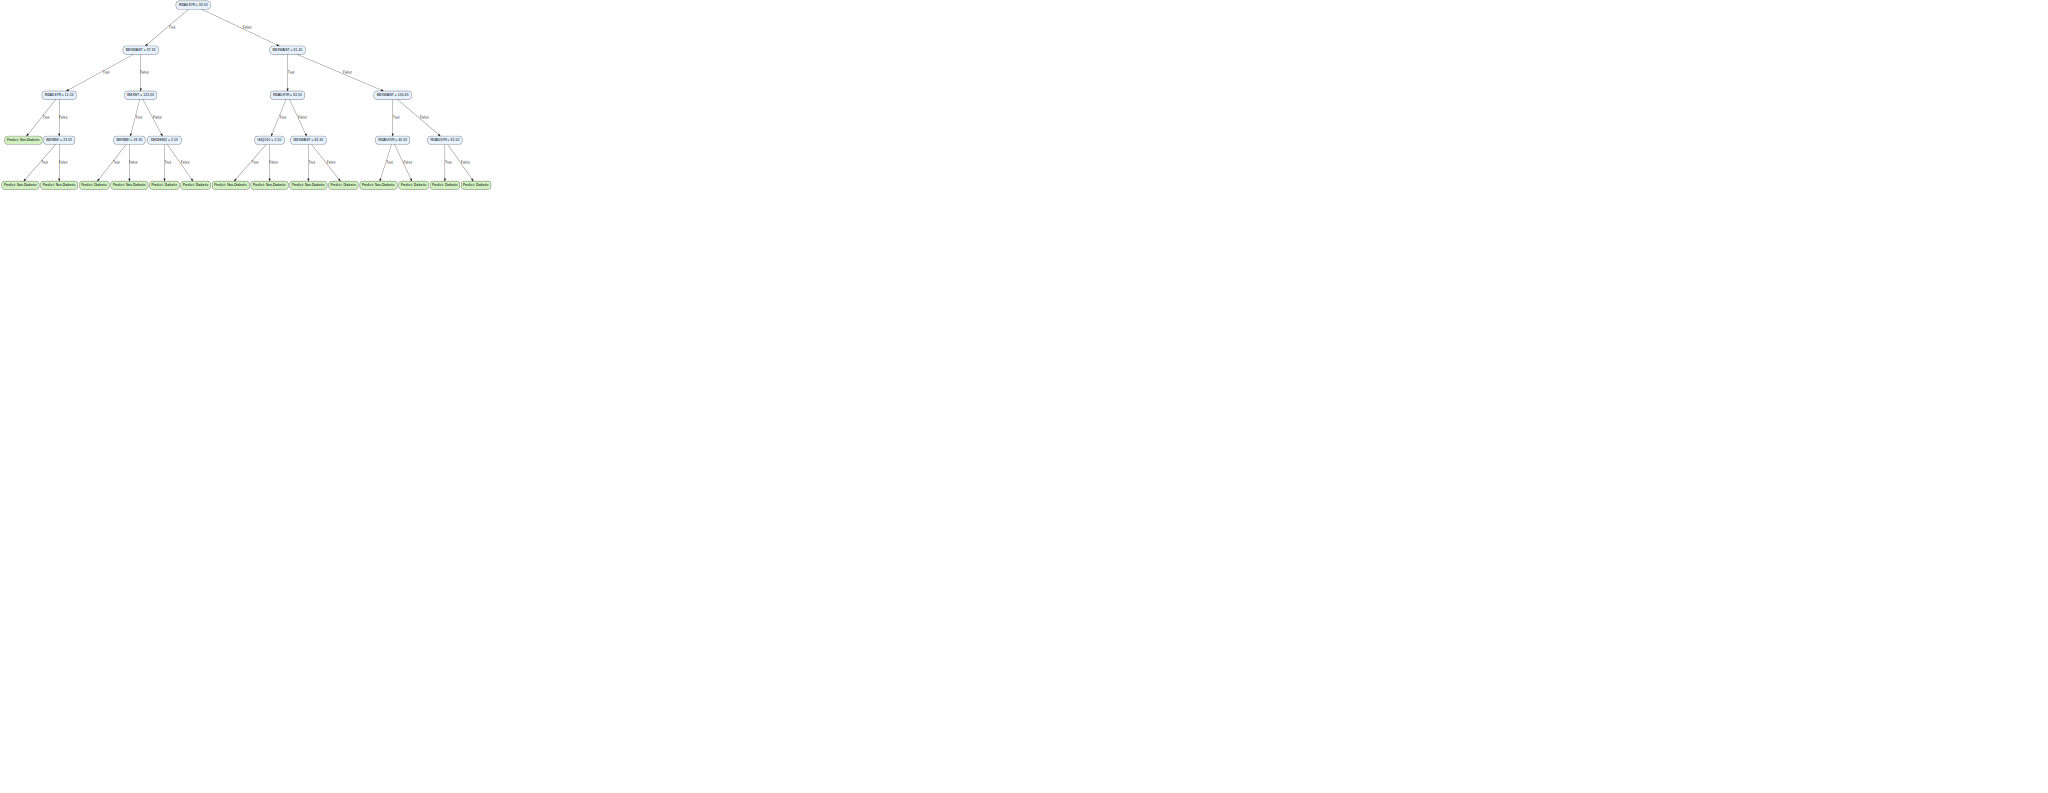

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import _tree
import graphviz
import pandas as pd

df = pd.read_csv('/workspaces/Final-Year-Project/Cleaned Data/TrainTestData.csv')
X_unscaled = df.drop('Diabetes Status', axis=1)
y = df['Diabetes Status']

dt = DecisionTreeClassifier(max_depth=4, random_state=42)
dt.fit(X_unscaled, y)

class_names = ['Non-Diabetic', 'Diabetic']

def traverse_tree(tree, feature_names):
    dot = ['digraph Tree {',
       'graph [nodesep=0.08, ranksep=2.0, dpi=300] ;',  # drop size
       'node [shape=box, style="filled,rounded", fontname=helvetica] ;',
       'edge [fontname=helvetica] ;']


    
    def node_label(node):
        if tree.children_left[node] == _tree.TREE_LEAF:
            value = tree.value[node][0]
            predicted_class = class_names[value.argmax()]
            return f'label="Predict: {predicted_class}", fillcolor="#d0f0c0"'
        else:
            feature = feature_names[tree.feature[node]]
            threshold = tree.threshold[node]
            return f'label="{feature} ≤ {threshold:.2f}", fillcolor="#e6f2ff"'

    def recurse(node):
        dot.append(f'{node} [{node_label(node)}] ;')
        if tree.children_left[node] != _tree.TREE_LEAF:
            for child, direction in [(tree.children_left[node], "True"), 
                                     (tree.children_right[node], "False")]:
                dot.append(f'{node} -> {child} [label="{direction}"] ;')
                recurse(child)

    recurse(0)
    dot.append('}')
    return '\n'.join(dot)

dot_string = traverse_tree(dt.tree_, feature_names=X_unscaled.columns)

graph = graphviz.Source(dot_string)
graph.render("decision_tree_clean", format='png', cleanup=False)
graph
